# FISTA

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import re
import gc

In [2]:
DATA_PATH = '../../../OneDrive - m.titech.ac.jp/Lab/data/'

In [3]:
def images_to_matrix(folder_path, convert_gray=False, is_binary=False, seed=0, ratio=1.0, use_all=False):
    files = os.listdir(folder_path)
    files.sort(key=lambda f: int(re.search('hadamard_(\d+).png', f).group(1)))

    if seed != 0:
        random.seed(seed)
        random.shuffle(files)

    total_files = len(files)
    number_of_files_to_load = int(total_files * ratio)

    if use_all:
        selected_files = files[:number_of_files_to_load]
        selected_files.sort(key=lambda f: int(re.search('hadamard_(\d+).png', f).group(1)))
    else:
        # 特定の一部
        selected_indices = []
        a = np.arange(0, 4096).reshape(64, 64)
        a = np.triu(a)
        a = a.flatten().tolist()
        selected_indices = [i for i in a if i != 0]
        selected_indices.insert(0, 0)
        for i in range(0, 64):
            range_i= list(range(63+63*i, 64*(i+1)))
            selected_indices += range_i
        selected_files = [files[i] for i in selected_indices if i < total_files]

    images = []
    use_list = []

    for file in selected_files:
        index = int(re.sub(r'\D', '', file))
        use_list.append(index)
        img = Image.open(os.path.join(folder_path, file))
        if convert_gray:
            img = img.convert('L')
        if is_binary:
            img = img.point(lambda x: 255 if x else 0, 'L')
        img_array = np.asarray(img).flatten()
        img_array = img_array / 255
        images.append(img_array)

    # diff = list(set(range(1, len(files)+1))-set(use_list))
    # print("Didn't use:", sorted(diff))
    print("Used:", use_list)

    return np.column_stack(images)


def update_H(H, G, F, lmd, threshold):
    i = 1
    t = 1
    L = max_eigenvalue(F.T @ F) * 3
    print('L: {}'.format(L))
    H_1_prev = H.copy()
    H_2_prev = H.copy()
    while True:
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        grad = 2 * (H_2_prev @ F - G) @ F.T
        H_1 = soft_thresh(H_2_prev - (1 / L) * grad, lmd / L)
        H_2 = H_1 + (t - 1) / t_new * (H_1 - H_1_prev)
        error = np.linalg.norm(H_2 - H_2_prev, 'fro')

        print('iter: {}, error: {}'.format(i, error))
        if error < threshold:
            break
        t = t_new.copy()
        H_1_prev = H_1.copy()
        H_2_prev = H_2.copy()
        i += 1
    return H_2


def max_eigenvalue(A):
    eigenvalues, eigenvectors = np.linalg.eig(A)
    return np.max(eigenvalues)


def soft_thresh(x, lambda_val):
    return np.sign(x) * np.maximum(np.abs(x) - lambda_val, 0)

In [4]:
# パラメータ設定
n = 64
m = 128
lmd = 10
threshold = 0.001
seed = 2

In [5]:
# 真のシステム行列の計算
G_full = images_to_matrix(DATA_PATH + 'hadamard' + str(n) + '_cap_R_230516_128/', convert_gray=True, use_all=True)
# F_full = images_to_matrix(DATA_PATH + 'Hadamard' + str(n) + '_input/', is_binary=True, use_all=True)
# H1 = np.zeros((m**2, n**2))
# G1s = []
# for i in range(n**2):
#     G1s.append(G_full[:, 0])
# H1 = np.column_stack(G1s)
# F_hat_full = 2 * F_full - 1
# G_hat_full = 2 * G_full - H1
# H_true = G_hat_full @ F_hat_full.T / (n**2)

Used: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 2

In [6]:
# del F_full
# del F_hat_full
# del G_hat_full
# gc.collect()

In [7]:
# np.save('../data/systemMatrix/H_matrix_true.npy', H_true)
H_true = np.load(DATA_PATH + 'systemMatrix/H_matrix_true.npy')

In [15]:
# 初期化
H = np.zeros((m**2, n**2))
ratio = 0.1

In [16]:
G = images_to_matrix(DATA_PATH + 'hadamard' + str(n) + '_cap_R_230516_128/', convert_gray=True, seed=seed, ratio=ratio, use_all=True)
F = images_to_matrix(DATA_PATH + 'Hadamard' + str(n) + '_input/', is_binary=True, seed=seed, ratio=ratio, use_all=True)
print(G.shape)
print(F.shape)

Used: [17, 32, 38, 62, 63, 68, 70, 78, 83, 85, 89, 91, 117, 120, 124, 150, 170, 173, 181, 191, 205, 207, 209, 213, 216, 239, 249, 250, 268, 293, 322, 323, 332, 338, 349, 357, 358, 363, 372, 405, 406, 421, 442, 451, 466, 483, 503, 516, 520, 534, 562, 570, 579, 582, 616, 623, 632, 645, 650, 653, 671, 675, 678, 683, 688, 706, 723, 728, 729, 730, 735, 736, 739, 774, 775, 776, 798, 800, 805, 833, 857, 872, 874, 894, 915, 952, 958, 963, 998, 1001, 1002, 1005, 1012, 1017, 1035, 1041, 1044, 1051, 1060, 1069, 1088, 1092, 1097, 1105, 1106, 1108, 1112, 1132, 1148, 1151, 1161, 1170, 1171, 1178, 1201, 1218, 1229, 1235, 1238, 1244, 1256, 1270, 1292, 1295, 1300, 1321, 1323, 1331, 1341, 1346, 1354, 1362, 1375, 1388, 1389, 1406, 1418, 1419, 1420, 1448, 1464, 1484, 1501, 1503, 1507, 1512, 1521, 1550, 1561, 1571, 1575, 1589, 1591, 1615, 1623, 1625, 1628, 1639, 1658, 1681, 1688, 1695, 1700, 1705, 1711, 1727, 1743, 1753, 1754, 1781, 1782, 1785, 1799, 1801, 1807, 1809, 1819, 1839, 1840, 1853, 1857, 1877, 18

In [17]:
H1 = np.zeros((m**2, 1))
G1s = []
for _ in range(F.shape[1]):
    G1s.append(G_full[:, 0])
H1 = np.column_stack(G1s)
F_hat = 2 * F - 1
G_hat = 2 * G - H1
print(F_hat.shape)
print(G_hat.shape)

(4096, 409)
(16384, 409)


In [18]:
# Hを更新
H = update_H(H, G_hat, F_hat, lmd, threshold)

np.save(DATA_PATH + 'systemMatrix/H_matrix_FISTA_10p.npy', H)

# plt.figure(figsize=(12, 8))
# sns.heatmap(H, annot=False, cmap='viridis')

L: 12288.0
iter: 1, error: 0.4749561230729864
iter: 2, error: 0.5158126931445277
iter: 3, error: 0.5474118564395998
iter: 4, error: 0.5701078338656644
iter: 5, error: 0.5823780535056586
iter: 6, error: 0.58319185338052
iter: 7, error: 0.5721198417841983
iter: 8, error: 0.5493447726486367
iter: 9, error: 0.5157236283838513
iter: 10, error: 0.4726327438420028
iter: 11, error: 0.4216532146765524
iter: 12, error: 0.36476801052417107
iter: 13, error: 0.3042529010422917
iter: 14, error: 0.2424938833719557
iter: 15, error: 0.18249479031100824
iter: 16, error: 0.12747014444262786
iter: 17, error: 0.08165487623170313
iter: 18, error: 0.051268436410117794
iter: 19, error: 0.04579428712997503
iter: 20, error: 0.057649218929105205
iter: 21, error: 0.07070584221343357
iter: 22, error: 0.07934775736774245
iter: 23, error: 0.08260334368703542
iter: 24, error: 0.08084002814929687
iter: 25, error: 0.07492463785812153
iter: 26, error: 0.06592799045855287
iter: 27, error: 0.0550110630409887
iter: 28, err

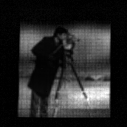

In [19]:
sample_image = Image.open(DATA_PATH + 'sample_image64/Cameraman64.png')
sample_image = sample_image.convert('L')
sample_image = np.asarray(sample_image).flatten() / 255

Hf = H @ sample_image
Hf_img = Hf.reshape(m, m)

# plt.figure(figsize=(12, 8))
# sns.heatmap(Hf_img, annot=False, cmap='viridis')

fig, ax = plt.subplots(figsize=Hf_img.shape[::-1], dpi=1, tight_layout=True)
ax.imshow(Hf_img, cmap='gray')
ax.axis('off')
filename = DATA_PATH + '240327/Cameraman64_' + str(ratio)
# fig.savefig(filename + '.png', dpi=1)
plt.show()

In [20]:
rem = np.linalg.norm(H_true-H, 'fro')
print(rem)

3.6736587781069283
